# Regresja liniowa w PyTorch
W tej sekcji wykorzystamy model uczenia maszynowego PyTorch do stopniowego wyznaczania prostej najlepszego dopasowania dla zbioru punktów danych. Podobnie jak w większości algorytmów regresji liniowej, chcemy zminimalizować błąd między naszym modelem a rzeczywistymi danymi, korzystając z <em>funkcji straty</em>, takiej jak błąd średniokwadratowy (MSE).

<img src='../_img/linear-regression-residuals.png' width='400' style="display: inline-block"><br>

Źródło obrazu: <a href='https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png'>https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png</a>

Na początek przygotujemy zbiór punktów danych, które wyglądają na losowe, ale spełniają znane równanie liniowe $y = 2x+1$.


## Wykonaj standardowe importy


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn  # będziemy często z tego korzystać

## Utwórz kolumnową macierz wartości X
Możemy od razu tworzyć tensory, zamiast konwertować z tablic NumPy.


In [2]:
X = torch.linspace(1, 50, 50).reshape(-1, 1)  # uwaga! nie ma tu requires_grad=True

# Odpowiada temu
# X = torch.unsqueeze(torch.linspace(1,50,50), dim=1)

## Utwórz „losową” tablicę wartości błędu
Chcemy uzyskać 50 losowych liczb całkowitych, które w sumie dają zero.


In [3]:
torch.manual_seed(71)  # dla powtarzalnych wyników
e = torch.randint(-8, 9, (50, 1), dtype=torch.float)
print(e.sum())

tensor(0.)


## Utwórz kolumnową macierz wartości y
Ustawimy własne parametry $\mathrm{weight} = 2$ oraz $\mathrm{bias} = 1$, a następnie dodamy składnik błędu.

$y$ będzie mieć ten sam kształt co $X$ i $e$.


In [4]:
y = 2 * X + 1 + e
print(y.shape, X.shape, e.shape, sep="\n")

torch.Size([50, 1])
torch.Size([50, 1])
torch.Size([50, 1])


## Wykreśl wyniki
Do rysowania musimy przekonwertować tensory na tablice NumPy.


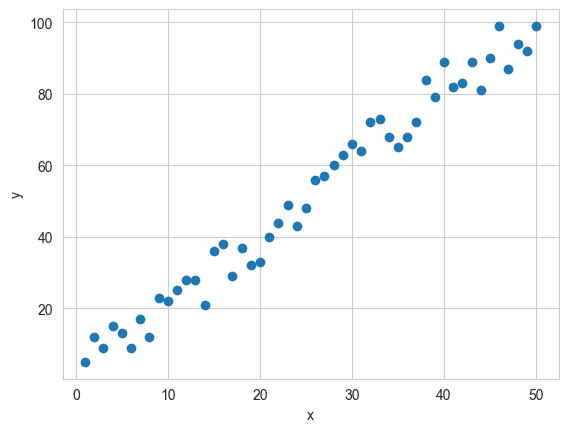

In [5]:
plt.scatter(X.numpy(), y.numpy())
plt.ylabel("y")
plt.xlabel("x");

Zwróć uwagę, że przy tworzeniu tensora $X$ <em>nie</em> ustawiliśmy `requires_grad=True`. Oznacza to, że $y$ nie ma funkcji gradientu i polecenie `y.backward()` nie zadziała. Ponieważ PyTorch nie śledzi operacji, nie zna zależności między $X$ a $y$.


## Prosty model liniowy
Jako szybka demonstracja pokażemy, jak wbudowany model `nn.Linear()` losowo wybiera wartości wagi i biasu.


In [6]:
torch.manual_seed(59)

model = nn.Linear(in_features=1, out_features=1)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1060]], requires_grad=True)
Parameter containing:
tensor([0.9638], requires_grad=True)


Bez analizowania danych model ustawia losową wagę 0.1060 i bias 0.9638.


## Klasy modeli
PyTorch pozwala definiować modele jako klasy obiektowe, które mogą przechowywać wiele warstw. 

W kolejnych sekcjach zbudujemy kilka warstw sieci neuronowej i określimy, jak każda z nich powinna wykonywać przekazanie w przód do następnej. Na razie potrzebujemy tylko pojedynczej warstwy `Linear`.


In [7]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

<div class="alert alert-info"><strong>UWAGA:</strong> Warstwa modelu „Linear” użyta tutaj nie odnosi się bezpośrednio do regresji liniowej. 

Opisuje ona typ warstwy sieci neuronowej. 

Warstwy liniowe nazywane są także „w pełni połączonymi” (ang. _fully connected_) lub „gęstymi” (ang. _dense_). 

W kolejnych przykładach nasze modele mogą zawierać warstwy liniowe, konwolucyjne i inne.</div>


Gdy tworzymy instancję klasy <tt>Model</tt>, musimy przekazać rozmiar (liczbę cech) na wejściu i wyjściu. 

W naszym przypadku użyjemy `(in_features=1, out_features=1)`.

Podobnie jak wcześniej, możemy podejrzeć początkowe parametry i hiperparametry.


In [8]:
torch.manual_seed(59)
model = Model(in_features=1, out_features=1)
print(model)
print("Weight:", model.linear.weight.item())
print("Bias:  ", model.linear.bias.item())

Model(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Weight: 0.10597813129425049
Bias:   0.9637961387634277


Wraz ze wzrostem złożoności modeli lepiej jest iterować po wszystkich parametrach modelu:


In [9]:
for name, param in model.named_parameters():
    print(name, "\t", param.item())

linear.weight 	 0.10597813129425049
linear.bias 	 0.9637961387634277


<div class="alert alert-info"><strong>UWAGA:</strong>  
W powyższym przykładzie nasza klasa `Model` przyjmowała argumenty, które określały liczbę cech wejściowych i wyjściowych.  

Dla prostoty możemy zakodować je na stałe w klasie `Model`:

```python
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = Linear(1, 1)

model = Model()
````

Możemy też użyć argumentów domyślnych:

```python
class Model(torch.nn.Module):
    def __init__(self, in_dim=1, out_dim=1):
        super().__init__()
        self.linear = Linear(in_dim, out_dim)

model = Model()
# albo
i = o = 1
model = Model(i, o)
```
Czyli takie standardowe pythonowe posługiwanie się klasami.

</div>


Przyjrzyjmy się teraz wynikowi po przekazaniu tensora do modelu.


In [10]:
x = torch.tensor([2.0])
print(model.forward(x))  # to samo co print(model(x))

tensor([1.1758], grad_fn=<ViewBackward0>)


co potwierdza równanie $f(x) = (0.1060)(2.0)+(0.9638) = 1.1758$.


## Wstępna ocena modelu

Możemy zestawić niewytrenowany model z naszym zbiorem danych, żeby zobaczyć punkt startowy.


In [11]:
x1 = np.array([X.min(), X.max()])
print(x1)

[ 1. 50.]


In [12]:
w1, b1 = model.linear.weight.item(), model.linear.bias.item()
print(f"Initial weight: {w1:.8f}, Initial bias: {b1:.8f}")
print()

y1 = x1 * w1 + b1
print(y1)

Initial weight: 0.10597813, Initial bias: 0.96379614

[1.0697743 6.2627025]


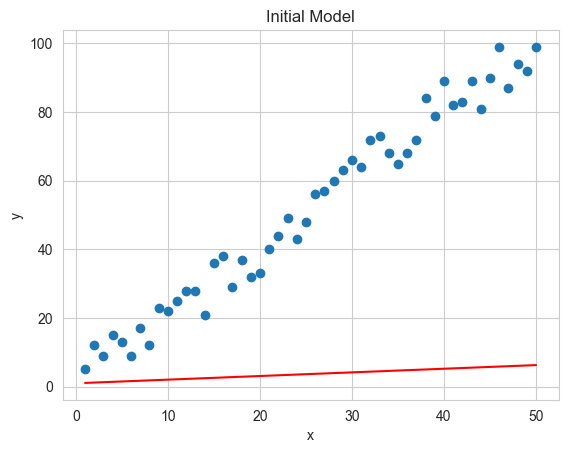

In [13]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1, y1, "r")
plt.title("Initial Model")
plt.ylabel("y")
plt.xlabel("x");

## Ustaw funkcję straty

Moglibyśmy napisać własną funkcję obliczającą błąd średniokwadratowy (MSE), która wygląda tak:<br>

$$
\begin{split}
MSE &= \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 \\
    &= \frac{1}{n} \sum_{i=1}^n \bigl(y_i - (w x_i + b)\bigr)^2
\end{split}
$$

Na szczęście PyTorch ma ją wbudowaną.

<em>Z przyzwyczajenia zmienną na funkcję straty nazywa się `criterion`, ale możesz użyć np. `linear_loss_func`, jeśli jest to bardziej przejrzyste.</em>


In [14]:
criterion = nn.MSELoss()

## Skonfiguruj optymalizator
Tutaj użyjemy <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>stochastycznego spadku gradientowego</a> (SGD) z <a href='https://en.wikipedia.org/wiki/Learning_rate'>współczynnikiem uczenia</a> $lr = 0.001$. 

Współczynnik uczenia określa, o ile należy skorygować każdy parametr podczas kolejnej iteracji. 
- Zbyt duży krok może spowodować „przestrzelenie” minimum i rozbieżność algorytmu.
- Zbyt mały krok oznacza wolną zbieżność.

Przy bardziej złożonych (wielowymiarowych) danych warto rozważyć przekazanie opcjonalnych argumentów <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum'><tt>momentum</tt></a> i <a href='https://en.wikipedia.org/wiki/Tikhonov_regularization'><tt>weight_decay</tt></a>.

Momentum pozwala algorytmowi „przetoczyć się” przez niewielkie nierówności i uniknąć zbyt wczesnego zatrzymania w minimach lokalnych. 

Zanikanie wag (L2 penalty) wpływa z kolei na biasy.

Więcej informacji znajdziesz w dokumentacji <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a>.


In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Czasem zobaczysz to w takiej formie
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

## Wytrenuj model
<em>Epoka</em> to pojedyncze przejście przez cały zbiór danych. 

Chcemy dobrać na tyle dużą liczbę epok, by osiągnąć plateau (wypłaszczenie) blisko znanych parametrów $\mathrm {weight} = 2$, $\mathrm {bias} = 1$, bo $y = 2 \cdot x + 1$


In [16]:
# liczba epok (pełnych przejść przez zbiór danych)
epochs = 50

# lista do zapisywania wartości straty, aby później móc np. narysować wykres
losses = []

for i in range(epochs):
    # zwiększamy licznik epoki (żeby numeracja zaczynała się od 1, a nie od 0)
    i += 1

    # obliczamy przewidywania modelu dla danych wejściowych X
    y_pred = model.forward(X)

    # obliczamy stratę (różnicę między przewidywaniami a etykietami y)
    loss = criterion(y_pred, y)

    # zapisujemy wartość straty do listy kontrolnej
    losses.append(loss)

    # wypisujemy aktualny stan uczenia: epokę, stratę oraz bieżące parametry modelu
    print(
        f"epoch: {i:2}  loss: {loss.item():10.8f}  "
        f"weight: {model.linear.weight.item():10.8f}  "
        f"bias: {model.linear.bias.item():10.8f}"
    )

    # zerujemy gradienty (żeby nie kumulowały się z poprzednich kroków)
    optimizer.zero_grad()

    # wykonujemy propagację wsteczną – obliczamy gradienty względem parametrów
    loss.backward()

    # aktualizujemy wagi i bias przy użyciu wybranego optymalizatora
    optimizer.step()

epoch:  1  loss: 3057.21679688  weight: 0.10597813  bias: 0.96379614
epoch:  2  loss: 1588.53112793  weight: 3.33490038  bias: 1.06046367
epoch:  3  loss: 830.29998779  weight: 1.01483274  bias: 0.99226284
epoch:  4  loss: 438.85241699  weight: 2.68179965  bias: 1.04252183
epoch:  5  loss: 236.76152039  weight: 1.48402119  bias: 1.00766504
epoch:  6  loss: 132.42912292  weight: 2.34460592  bias: 1.03396463
epoch:  7  loss: 78.56572723  weight: 1.72622538  bias: 1.01632178
epoch:  8  loss: 50.75775909  weight: 2.17050409  bias: 1.03025162
epoch:  9  loss: 36.40123367  weight: 1.85124576  bias: 1.02149546
epoch: 10  loss: 28.98922920  weight: 2.08060074  bias: 1.02903891
epoch: 11  loss: 25.16238213  weight: 1.91576838  bias: 1.02487016
epoch: 12  loss: 23.18647385  weight: 2.03416562  bias: 1.02911627
epoch: 13  loss: 22.16612625  weight: 1.94905841  bias: 1.02731562
epoch: 14  loss: 21.63911057  weight: 2.01017213  bias: 1.02985907
epoch: 15  loss: 21.36677170  weight: 1.96622372  bias

## Wykres strat
Sprawdźmy, jak zmieniała się wartość straty w czasie.


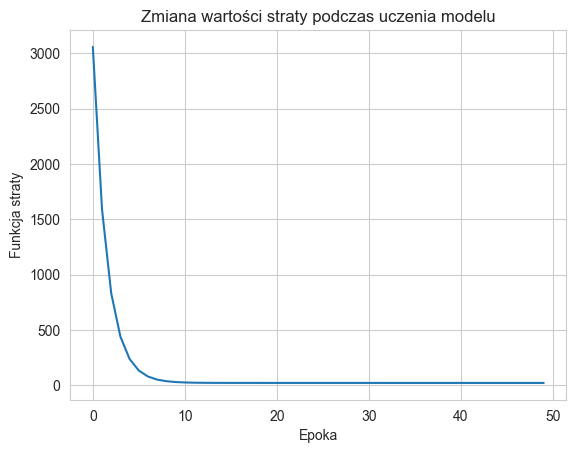

In [17]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses])
plt.xlabel("Epoka")  # oś X - numer epoki
plt.ylabel("Funkcja straty")  # oś Y - wartość straty
plt.title("Zmiana wartości straty podczas uczenia modelu")  # tytuł wykresu
plt.grid(True)  # siatka dla lepszej czytelności
plt.show()

## Wykreśl rezultat
Wyznaczymy teraz <tt>y1</tt> z nowego modelu, aby narysować najnowszą prostą najlepszego dopasowania.


In [18]:
w1, b1 = model.linear.weight.item(), model.linear.bias.item()
print(f"Current weight: {w1:.8f}, Current bias: {b1:.8f}")
print()

y1 = x1 * w1 + b1
print(x1)
print(y1)

Current weight: 1.98381913, Current bias: 1.05575156

[ 1. 50.]
[  3.0395708 100.246704 ]


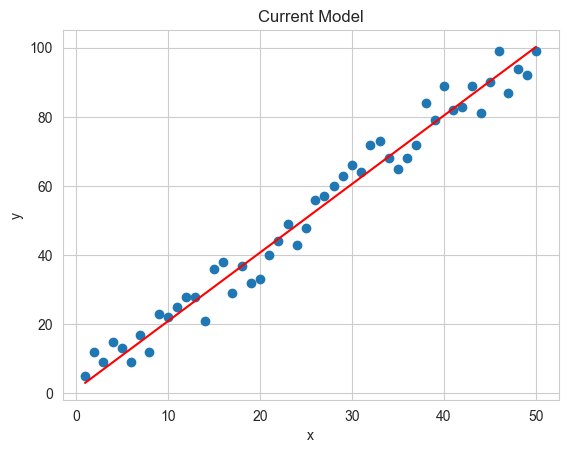

In [19]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(x1, y1, "r")
plt.title("Current Model")
plt.ylabel("y")
plt.xlabel("x")
plt.grid(True)
plt.show()

# Regresja liniowa w TensorFlow


Epoch 1/50


/Users/rkorzen/workspace/szkolenia/szkolenie_DL/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6515.2026 
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2827.2087
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 438.7646
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 136.5567
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 67.1241
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 29.7653
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 33.7216
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 29.9485
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 39.3523
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 35.0605
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 45.6472
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 36.9473
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 24.4161
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 24.8524
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 44.7369
Epoch 16/50
2/2 ━━━━━━━

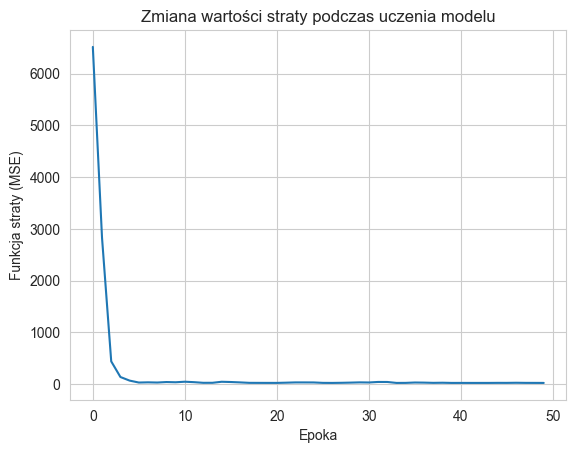

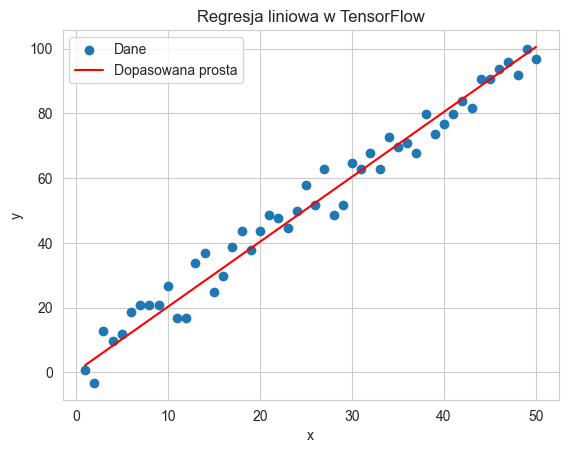

In [20]:
# %%writefile 10_Linear_regression_with_tensorflow.py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os



# # --- dane ---
# np.random.seed(71)

# X: wartości od 1 do 50
X = np.linspace(1, 50, 50).reshape(-1, 1)

# błąd losowy (suma ~0)
e = np.random.randint(-8, 9, (50, 1))
e = e - e.mean()

# y = 2x + 1 + szum
y = 2 * X + 1 + e

# --- model ---
# Definiujemy prosty model sekwencyjny z jedną warstwą Dense
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])

# --- kompilacja ---
# Używamy MSE jako loss i SGD jako optymalizatora
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss="mse")

# --- trening ---
history = model.fit(X, y, epochs=50, verbose=1)

# --- ocena wyników ---
# Wagi i bias
w, b = model.layers[0].get_weights()
print(f"Wytrenowana waga: {w[0][0]:.6f}, bias: {b[0]:.6f}")


# --- wykres straty ---
plt.plot(history.history["loss"])
plt.xlabel("Epoka")
plt.ylabel("Funkcja straty (MSE)")
plt.title("Zmiana wartości straty podczas uczenia modelu")
plt.grid(True)
plt.show()

# --- wizualizacja dopasowania ---
x_line = np.array([X.min(), X.max()])
y_line = w[0][0] * x_line + b[0]

plt.scatter(X, y, label="Dane")
plt.plot(x_line, y_line, "r", label="Dopasowana prosta")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regresja liniowa w TensorFlow")
plt.legend()
plt.grid(True)
plt.show()

# Świetna robota!

Dowiedzieliśmy się, jak:

* przygotować dane do regresji liniowej,
* zdefiniować prosty model w PyTorch (zarówno z `nn.Linear`, jak i jako własną klasę),
* zastosować funkcję straty (MSE) i optymalizator (SGD),
* przeprowadzić trening krok po kroku z obliczaniem gradientów i aktualizacją parametrów,
* a na końcu zwizualizować zarówno przebieg straty, jak i dopasowaną prostą.

Dzięki temu mamy pełny obraz, jak działa **regresja liniowa w PyTorch** – od danych po gotowy, wytrenowany model.

Powtórzyliśmy też ten proces dla Tensorflow.
